# Plot data for each example

- Fingerprints for an optimized pose cluster
- Pair features for optimized pose cluster

In [19]:
import sys
import os
import numpy as np
sys.path.append('../1_dock')
sys.path.append('../2_ifp')
sys.path.append('../3_analyze')
from prob_opt import PredictStructs
from containers import Dataset
from shared_paths import shared_paths
from statistics import Statistics, readf
from utils import export, show_side_by_side, show_features

shared_paths['data'] = '/Users/jpaggi/Documents/combind/combind_sherlock/bpp_data'

import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
# Read settings
def read_settings(root):
    tr = {}
    with open('{}/settings.py'.format(root)) as f:
        for line in f:
            var,val = line.split('=')
            tr[var] = eval(val)
    return tr

def read_stats(root, settings):
    idx = [-1, 0, 1]
    stats = Statistics({}, {}, settings['k_list'])
    for k in settings['k_list']:
        tmp = readf('{}/stats_{}.txt'.format(root, k), k, idx)
        for i in idx:
            stats.dist[i][k] = tmp[i]
    return stats
            
def read_score_file(fname):
    """
    Returns a dictionary of {lig_name: pose, ...} stored
    in FNAME.
    """
    pose_cluster = {}
    with open(fname) as fp:
        for line in fp:
            tok = line.strip().split(',')
            if tok[0] != 'max_score':
                pose_cluster[tok[0]] = int(tok[1])
    return pose_cluster
            
def read_data(protein, shared_paths, pose_cluster):
    cwd = os.getcwd()
    data = Dataset(shared_paths, [protein])
    data.load({protein: list(set([lig for lig in pose_cluster]))},
              load_mcss = False, load_fp = True)
    os.chdir(cwd)
    return data

In [43]:
ls /Users/jpaggi/Documents/combind/combind_sherlock/bpp_data/SMO/scores/all_best_affinity/t=0.001,n=1/


0.sh                 4QIN_lig-to-4JKV.sc  stats_contact.txt
4JKV_lig-to-4JKV.sc  5L7I_lig-to-4JKV.sc  stats_hbond.txt
4N4W_lig-to-4JKV.sc  5V57_lig-to-4JKV.sc  stats_mcss.txt
4O9R_lig-to-4JKV.sc  settings.py          stats_pipi.txt
4QIM_lig-to-4JKV.sc  slurm-23904266.out   stats_sb2.txt


In [44]:
protein = 'SMO'
scores = 'all_best_affinity/t=0.03,n=30'
cluster_file = '5L7I_lig-to-4JKV.sc'

root = '{}/{}/scores/{}'.format(shared_paths['data'], protein, scores)

In [45]:
settings = read_settings(root)
stats = read_stats(root, settings)
pose_cluster = read_score_file("{}/{}".format(root, cluster_file))
data = read_data(protein, shared_paths, pose_cluster)
ps = PredictStructs(data.proteins[protein], stats, settings['k_list'], 100, settings['t'])

In [46]:
l_list = sorted(pose_cluster.keys())
combind_top = ps.get_poses(pose_cluster)
glide_top   = ps.get_poses({l:0 for l in pose_cluster})

# Fingerprints

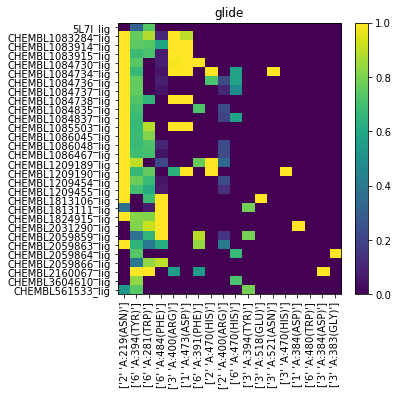

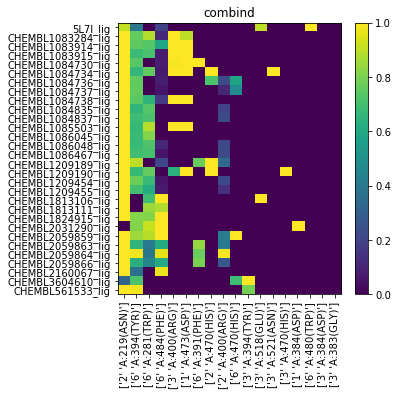

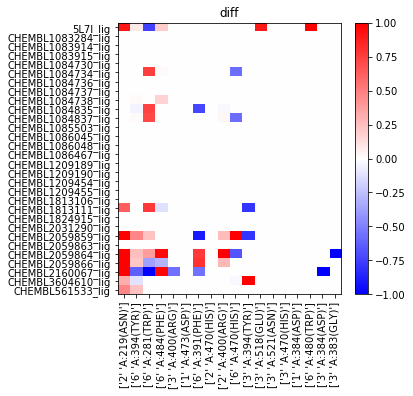

In [47]:
feature_defs = {
    'mcss':[],
    'hbond':[2,3],
    'sb2':[1],
    'pipi':[6],
    #'contact':[11]
}

interactions = sorted(set([interaction
                           for pose in combind_top.values()+glide_top.values()
                           for interaction in pose.fp.keys()
                           if interaction[0] in [idx for idxs in feature_defs.values() for idx in idxs]]))

# All poses to get indices
X = np.zeros((2*len(pose_cluster), len(interactions)))
for i, lig in enumerate(l_list):
    for j, interaction in enumerate(interactions):
        if interaction in combind_top[lig].fp:
            X[2*i+1, j] = combind_top[lig].fp[interaction]
        if interaction in glide_top[lig].fp:
            X[2*i+0, j] = glide_top[lig].fp[interaction]
X /= X.max(axis = 0).reshape(1, -1)
indices = [i for v, i in sorted([(v, i) for i, v in enumerate(X.sum(axis = 0))], reverse = True)]
X = X[:, indices]

plt.figure(figsize = (5, 5))
plt.title('glide')
plt.imshow(X[range(0, 2*len(l_list), 2)], aspect = 'auto')
plt.yticks(range(len(l_list)), l_list)
plt.xticks(range(len(interactions)), np.array(interactions)[indices], rotation='vertical')
plt.colorbar()
plt.show()

plt.figure(figsize = (5, 5))
plt.title('combind')
plt.imshow(X[range(1, 2*len(l_list), 2)], aspect = 'auto')
plt.yticks(range(len(l_list)), l_list)
plt.xticks(range(len(interactions)), np.array(interactions)[indices], rotation='vertical')
plt.colorbar()
plt.show()

plt.figure(figsize = (5, 5))
plt.title('diff')
plt.imshow(X[range(1, 2*len(l_list), 2)] - X[range(0, 2*len(l_list), 2)], aspect = 'auto', cmap = 'bwr')
plt.yticks(range(len(l_list)), l_list)
plt.xticks(range(len(interactions)), np.array(interactions)[indices], rotation='vertical')
plt.colorbar()
plt.show()

In [48]:
'+'.join(interaction[1].split(':')[1].split('(')[0] for interaction in interactions)

'384+473+219+400+470+383+384+394+400+470+518+521+281+391+394+470+480+484'

# Interactions

sb2 x_k matrix


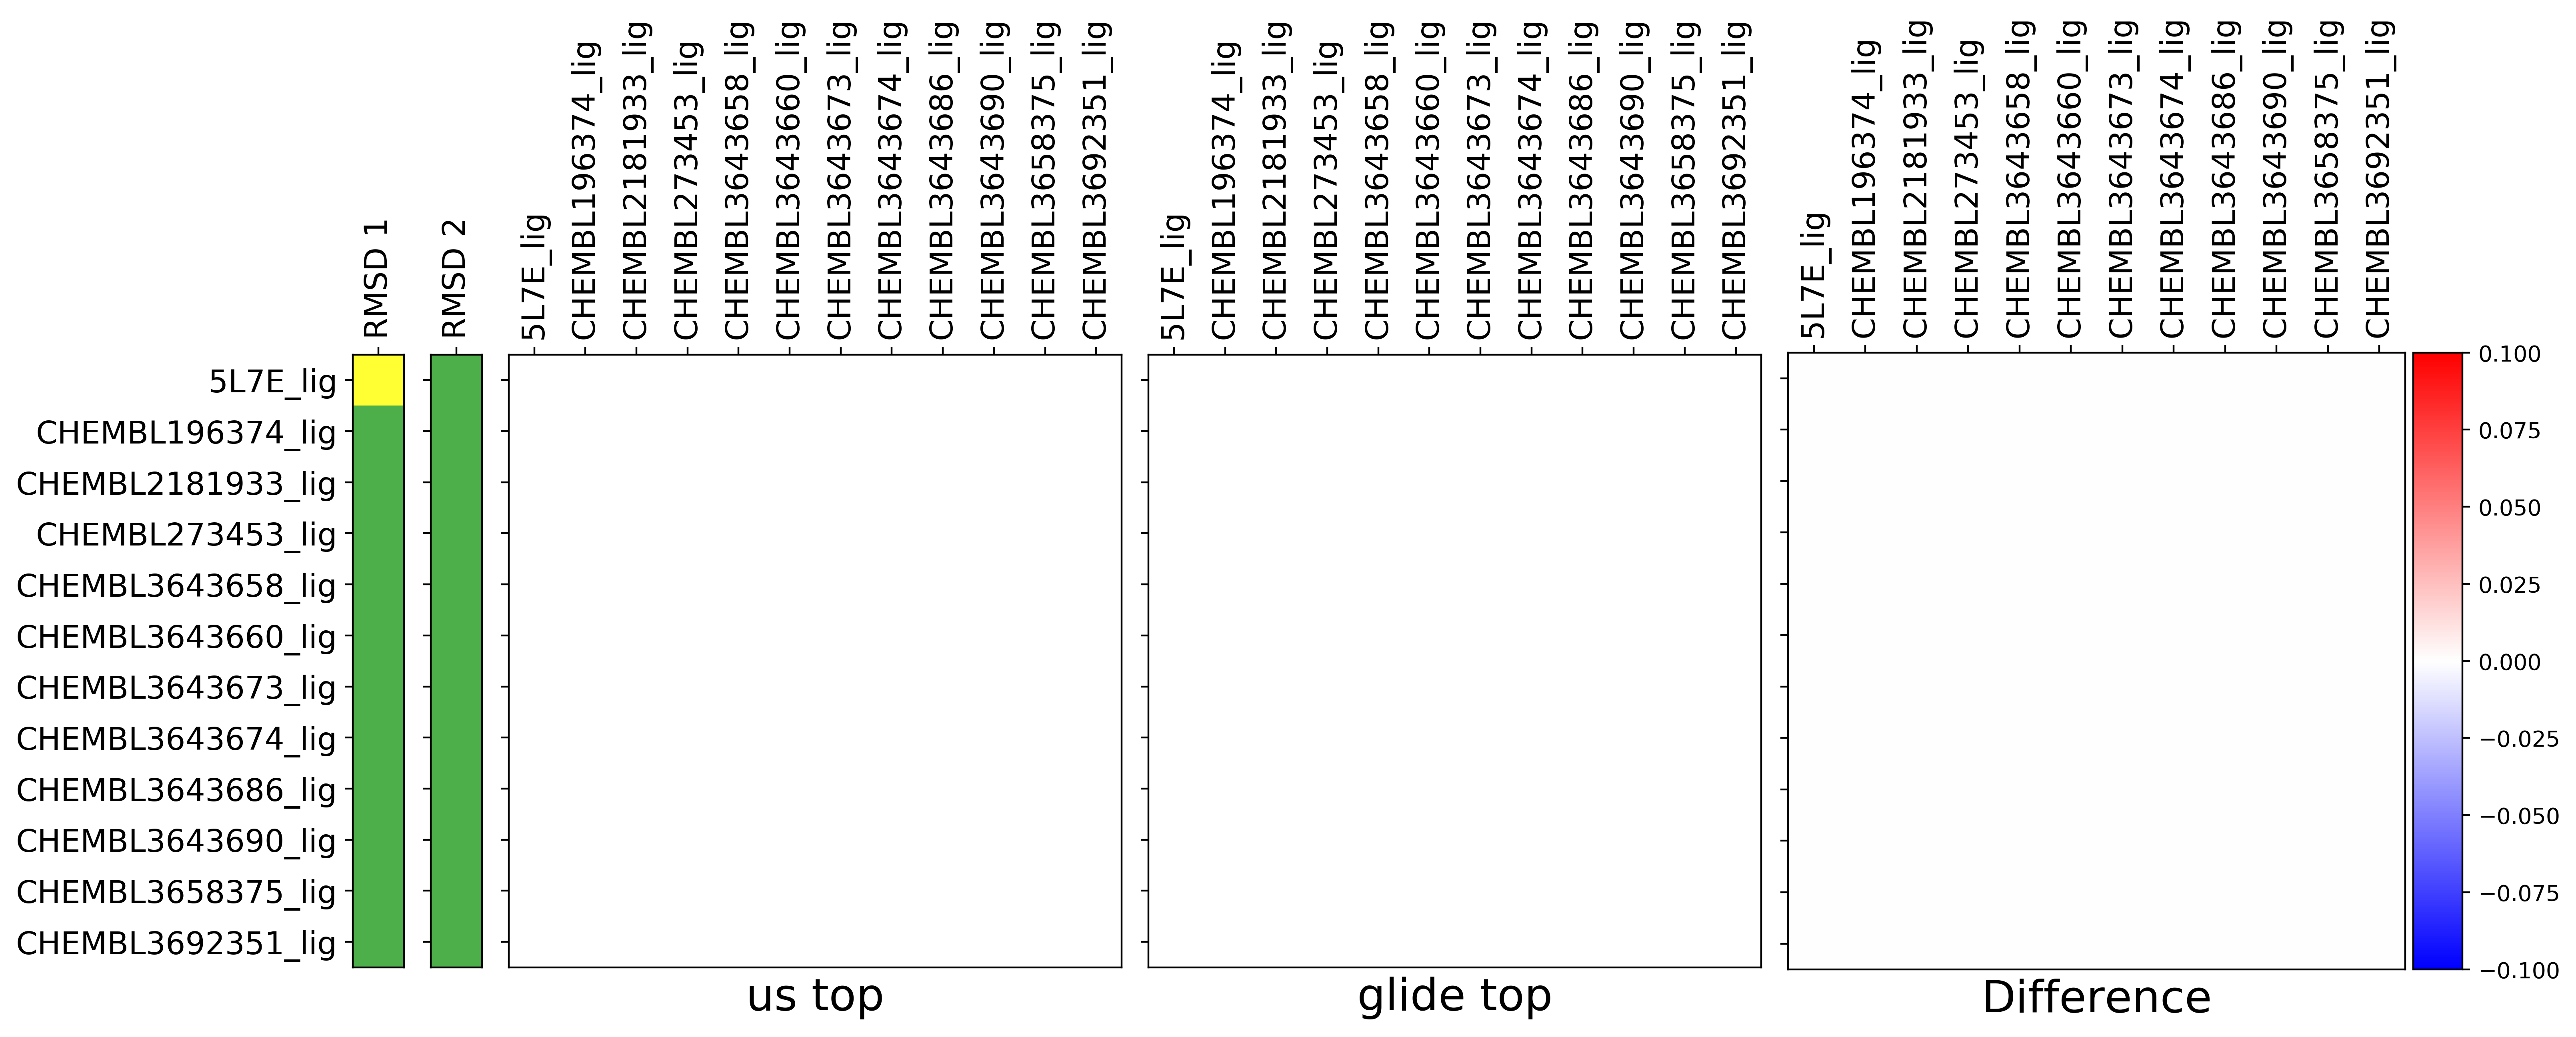

pipi probability matrix


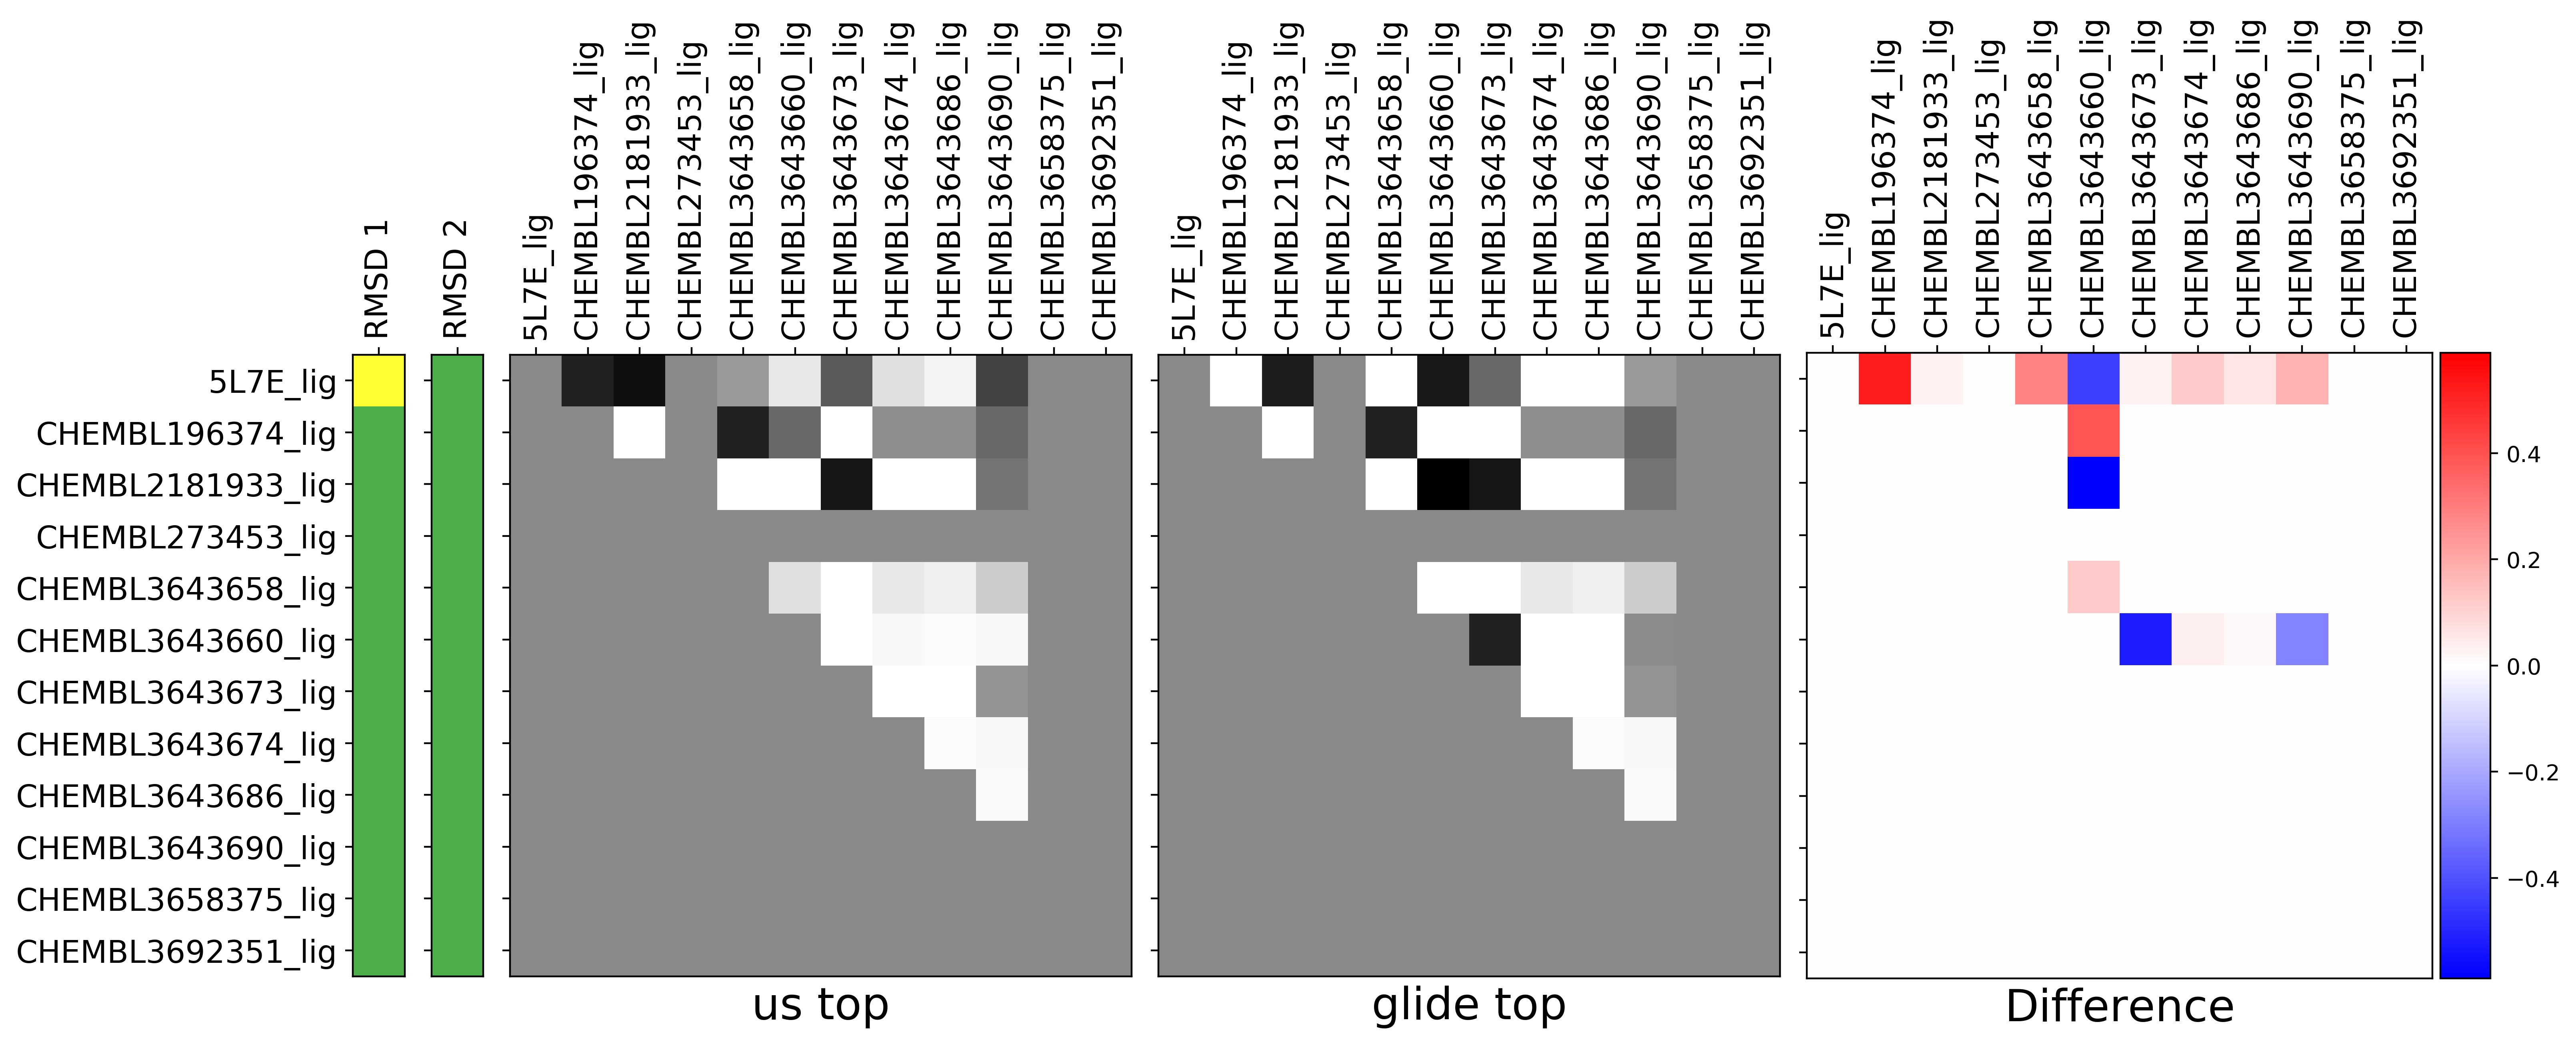

pipi x_k matrix


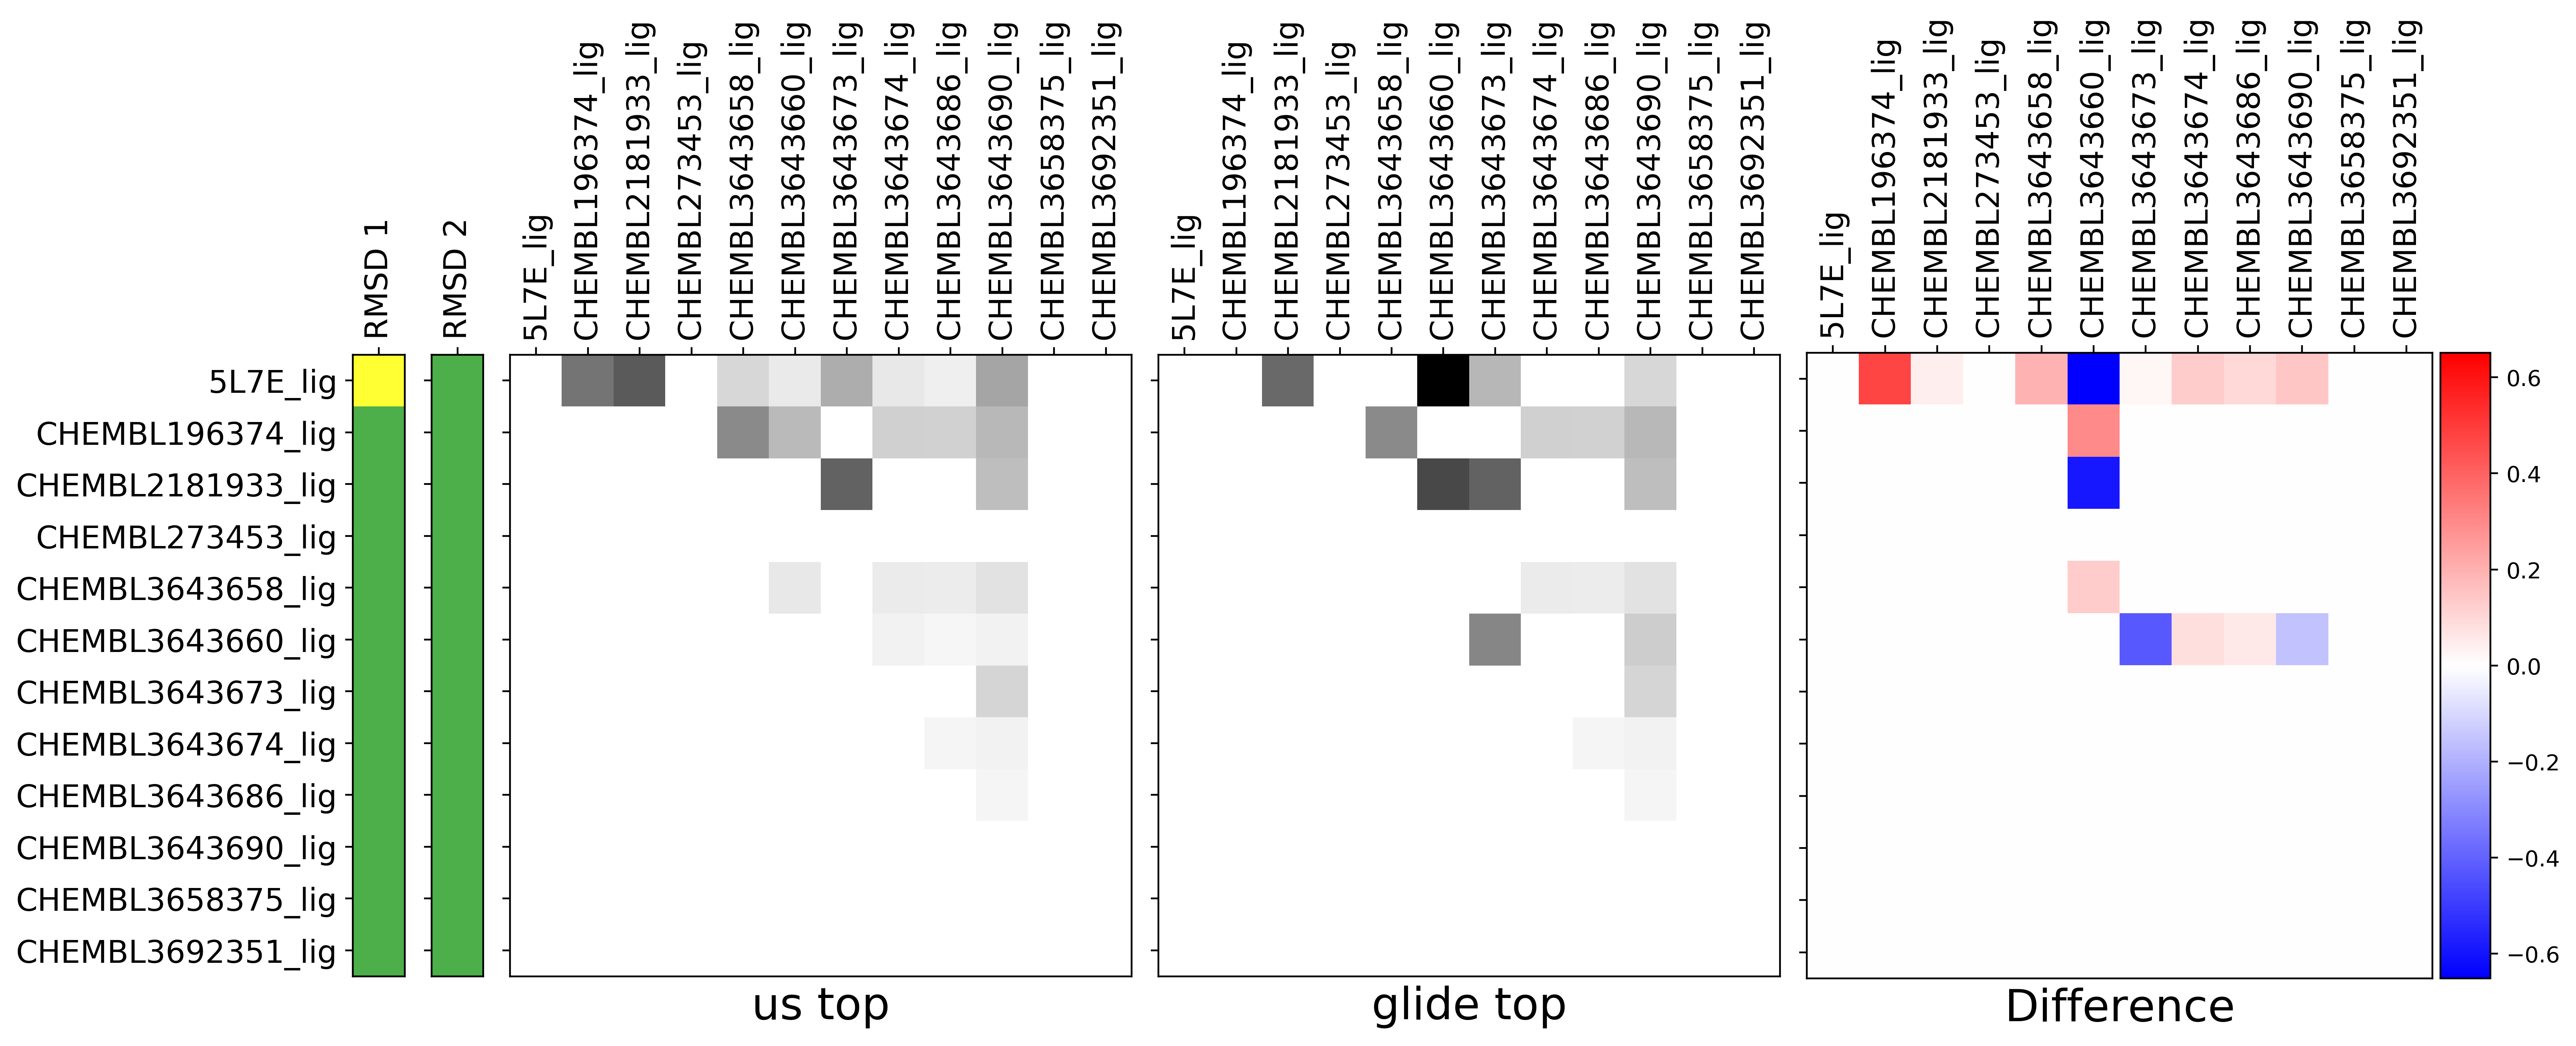

hbond probability matrix


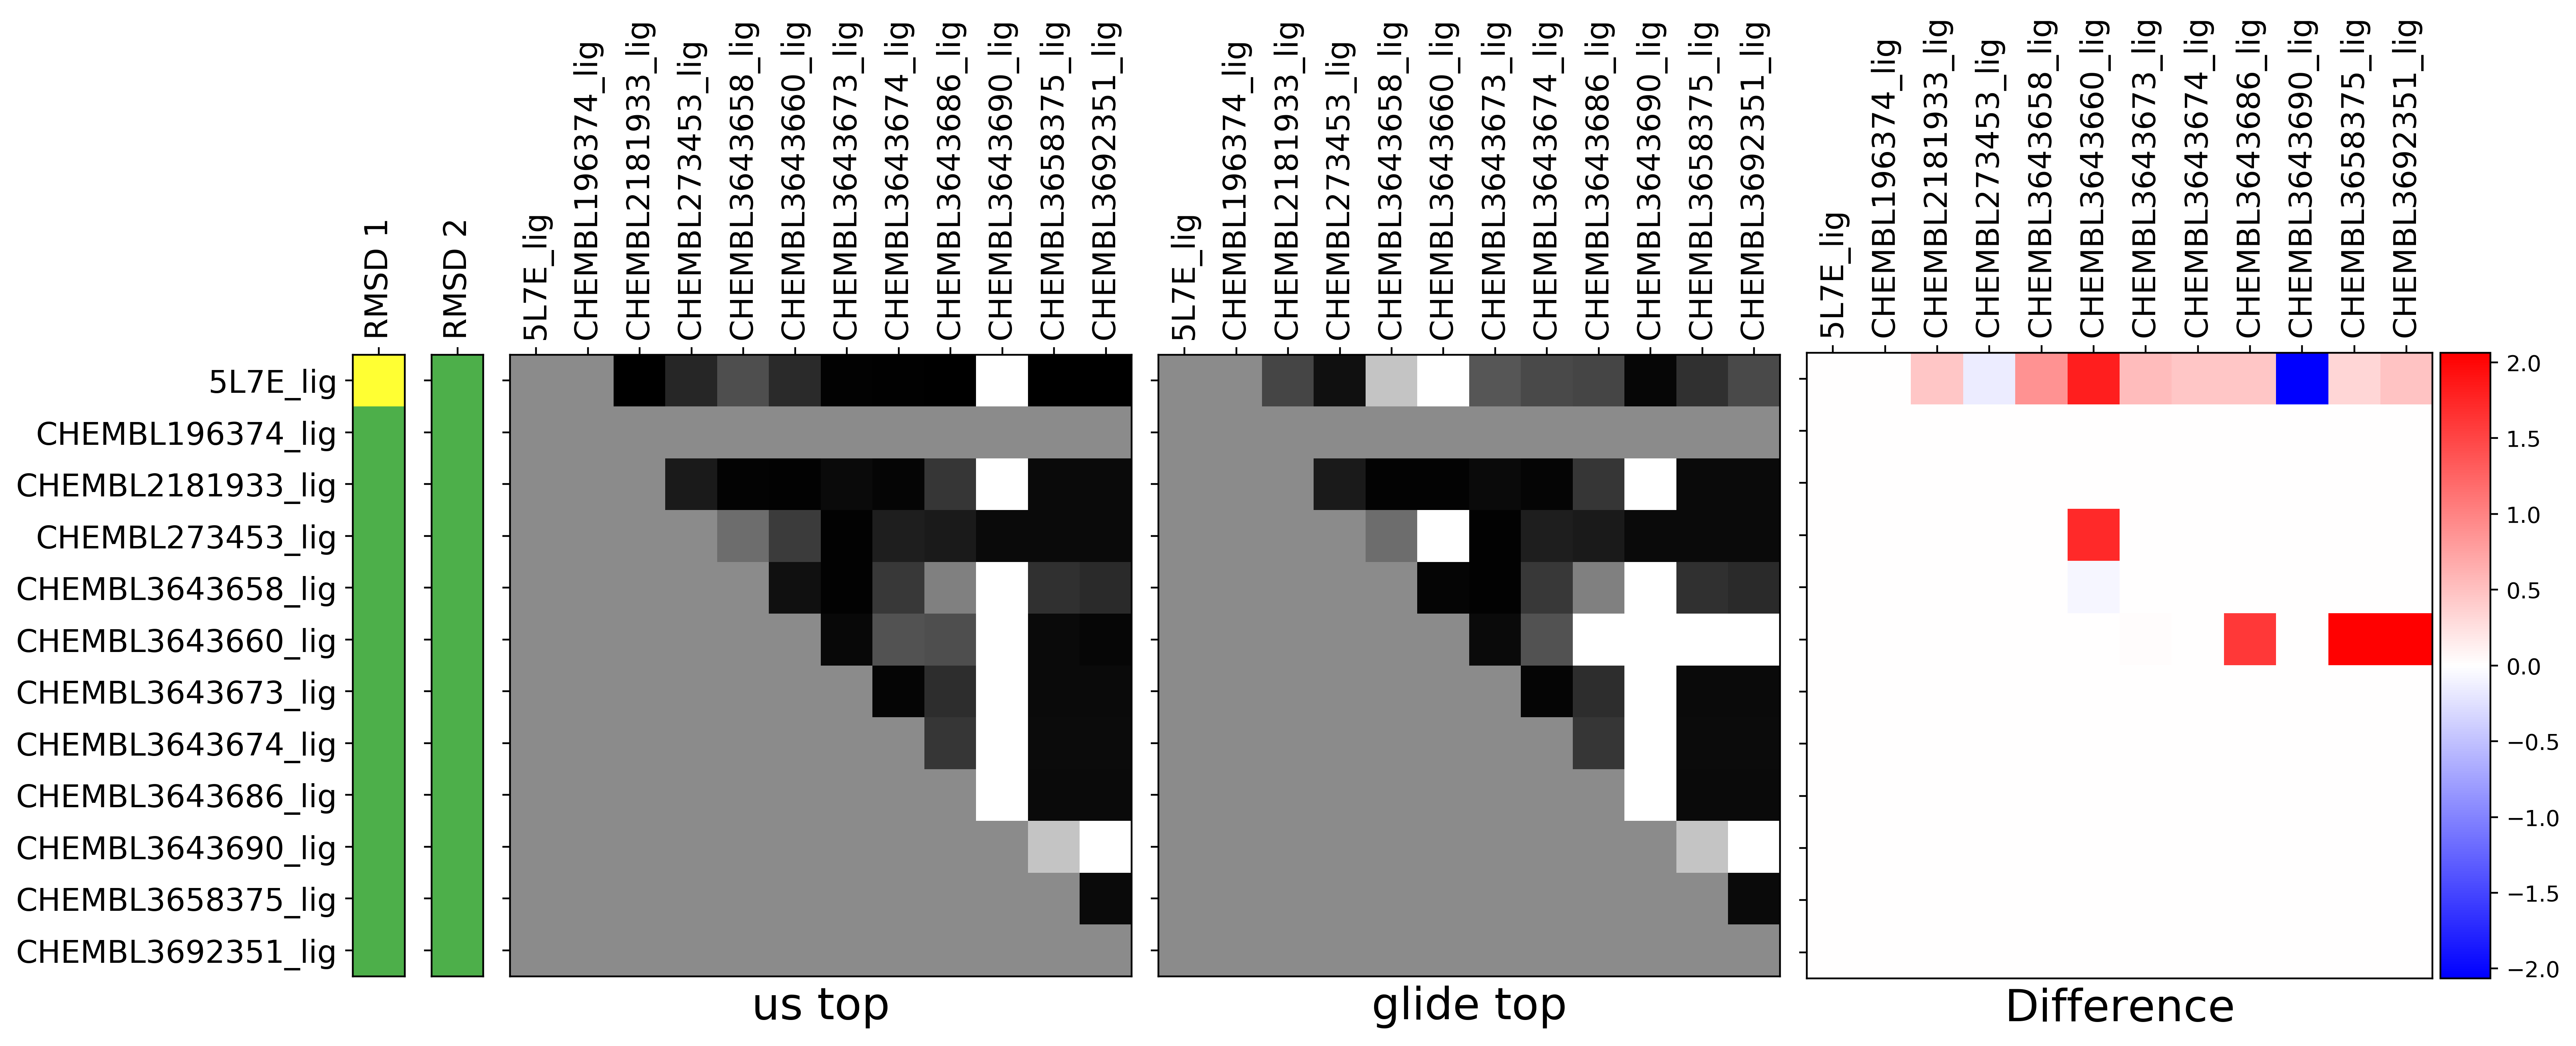

hbond x_k matrix


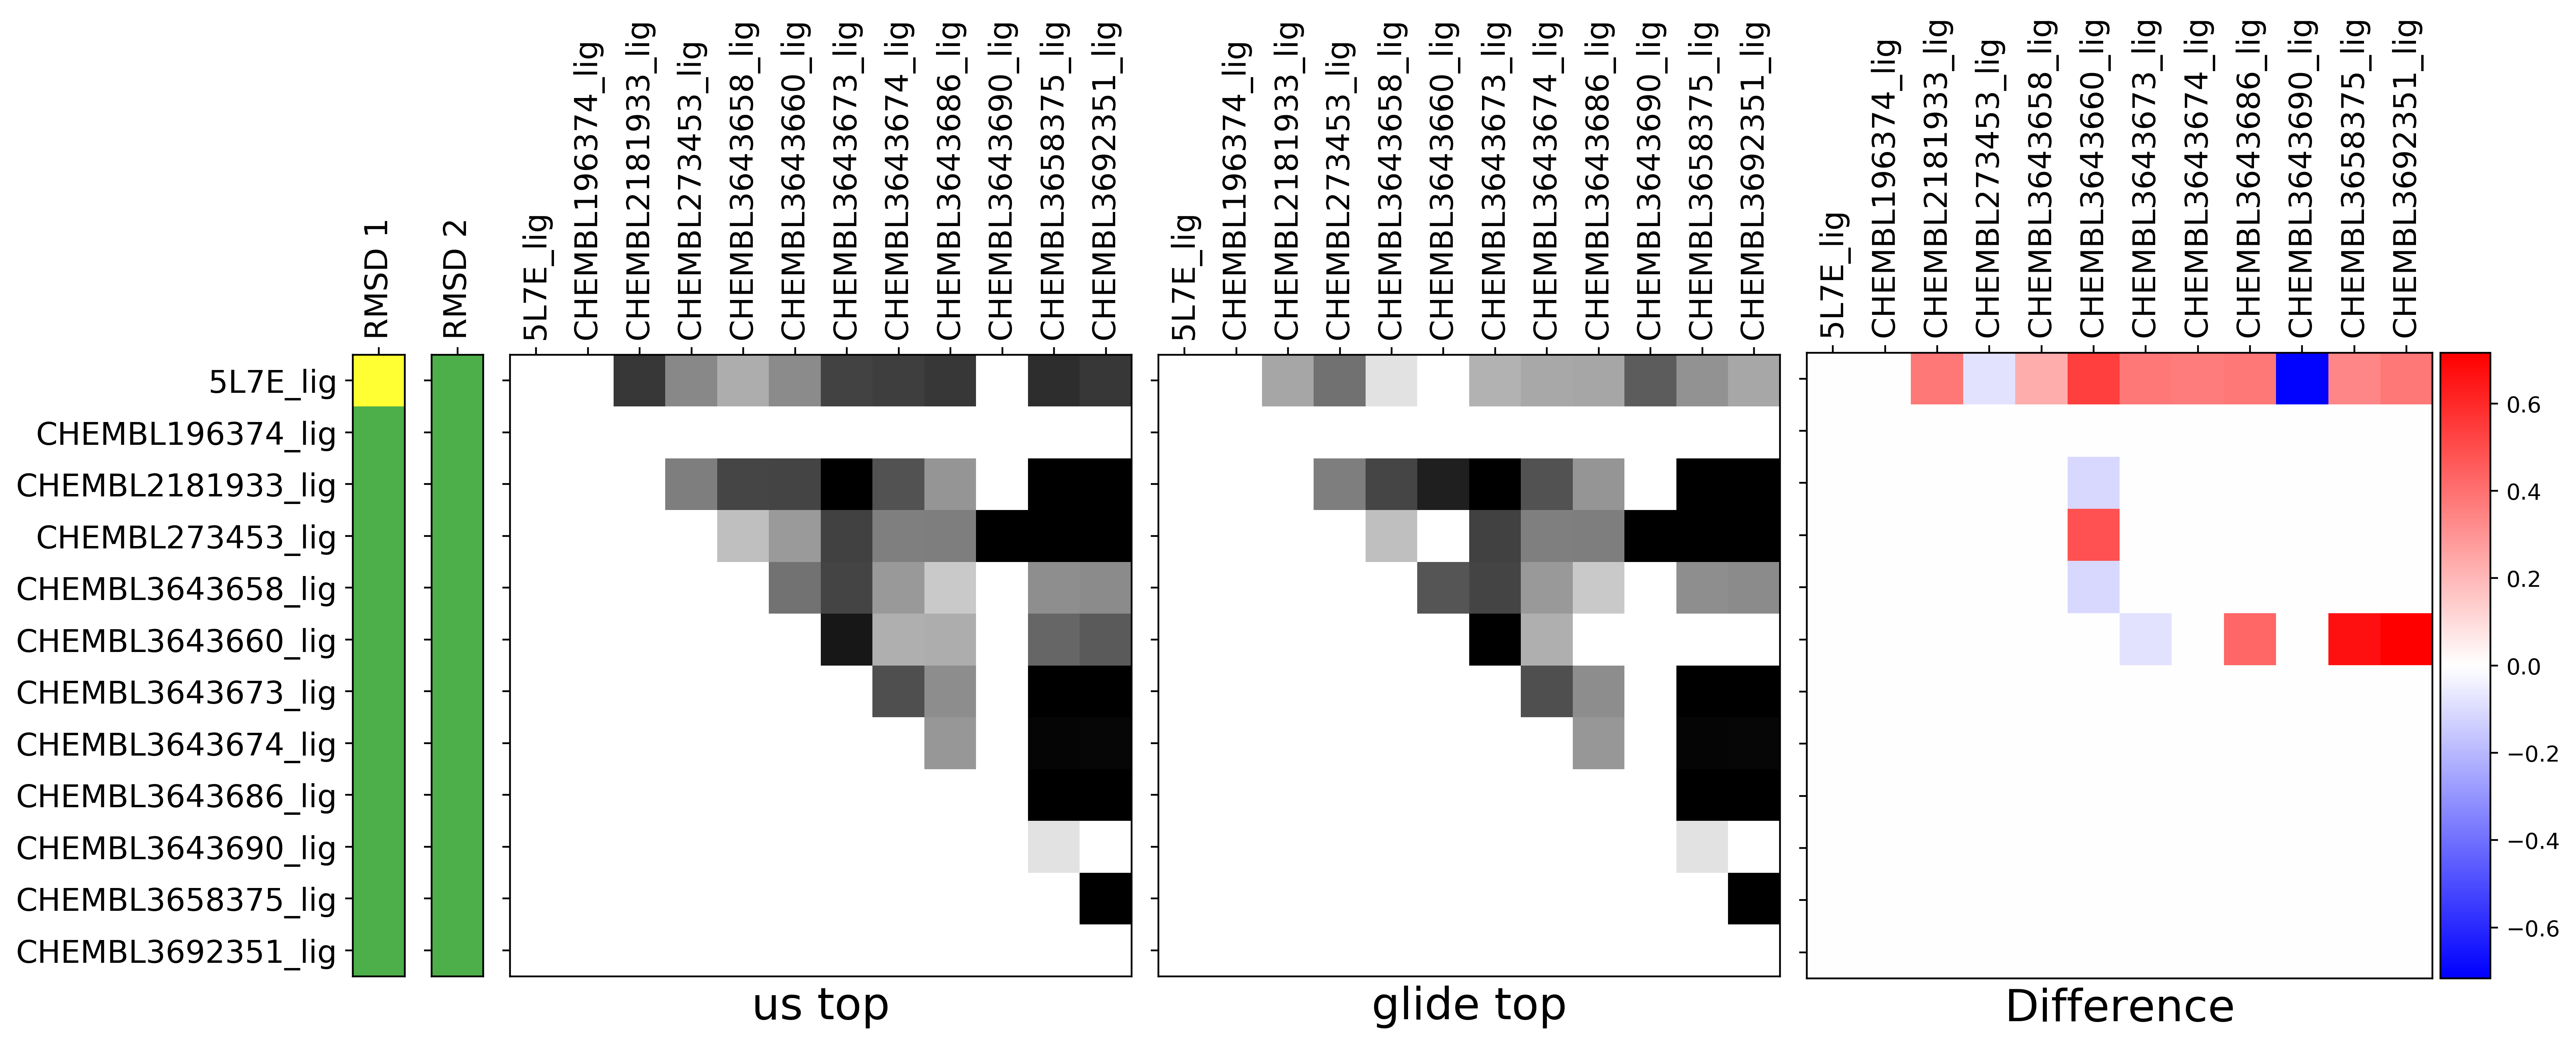

contact probability matrix


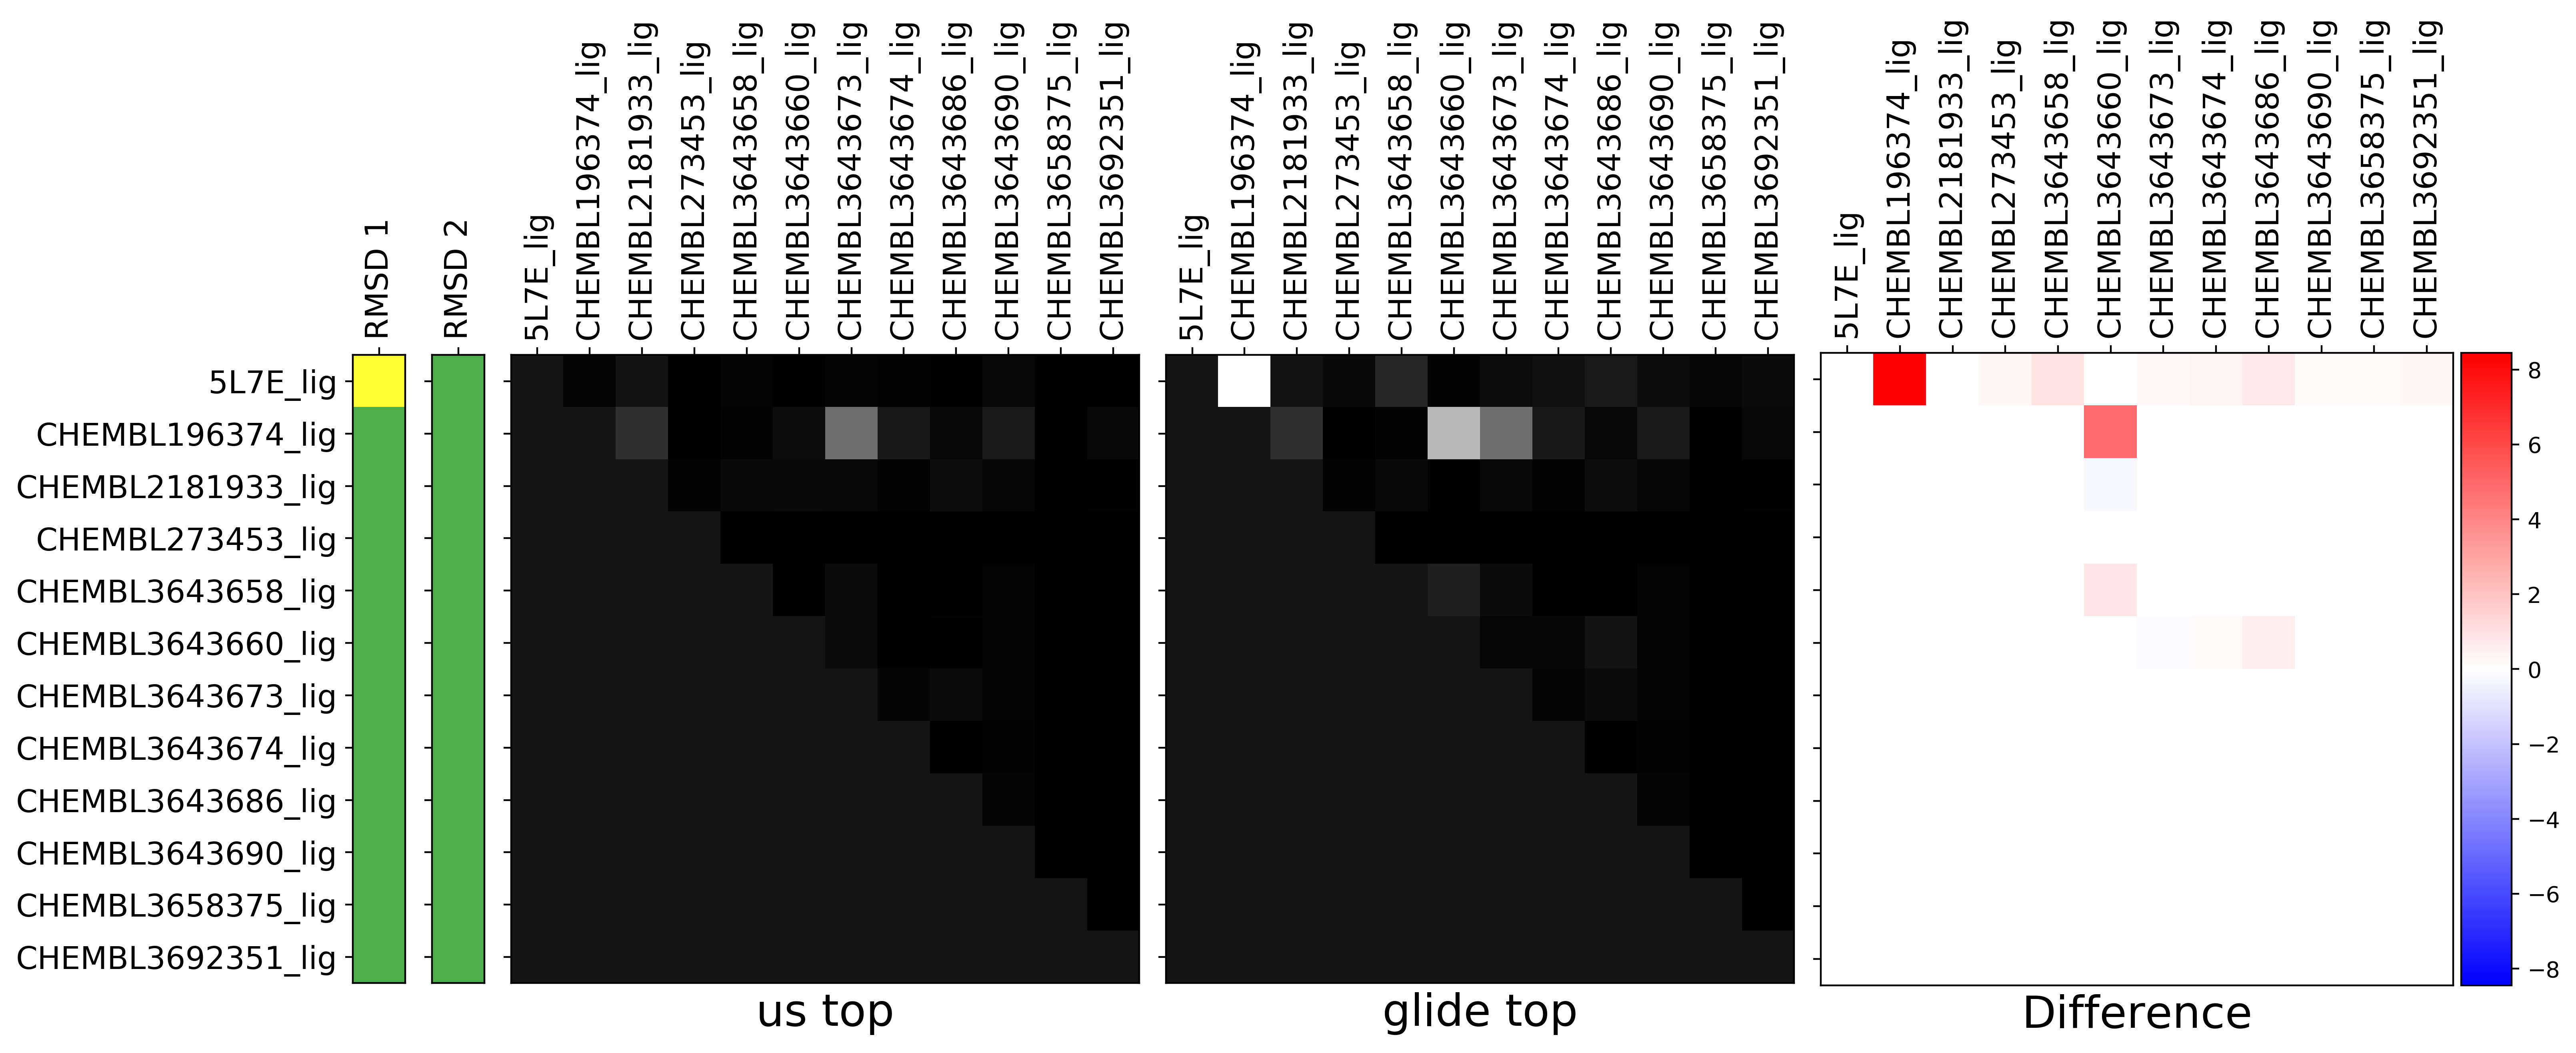

contact x_k matrix


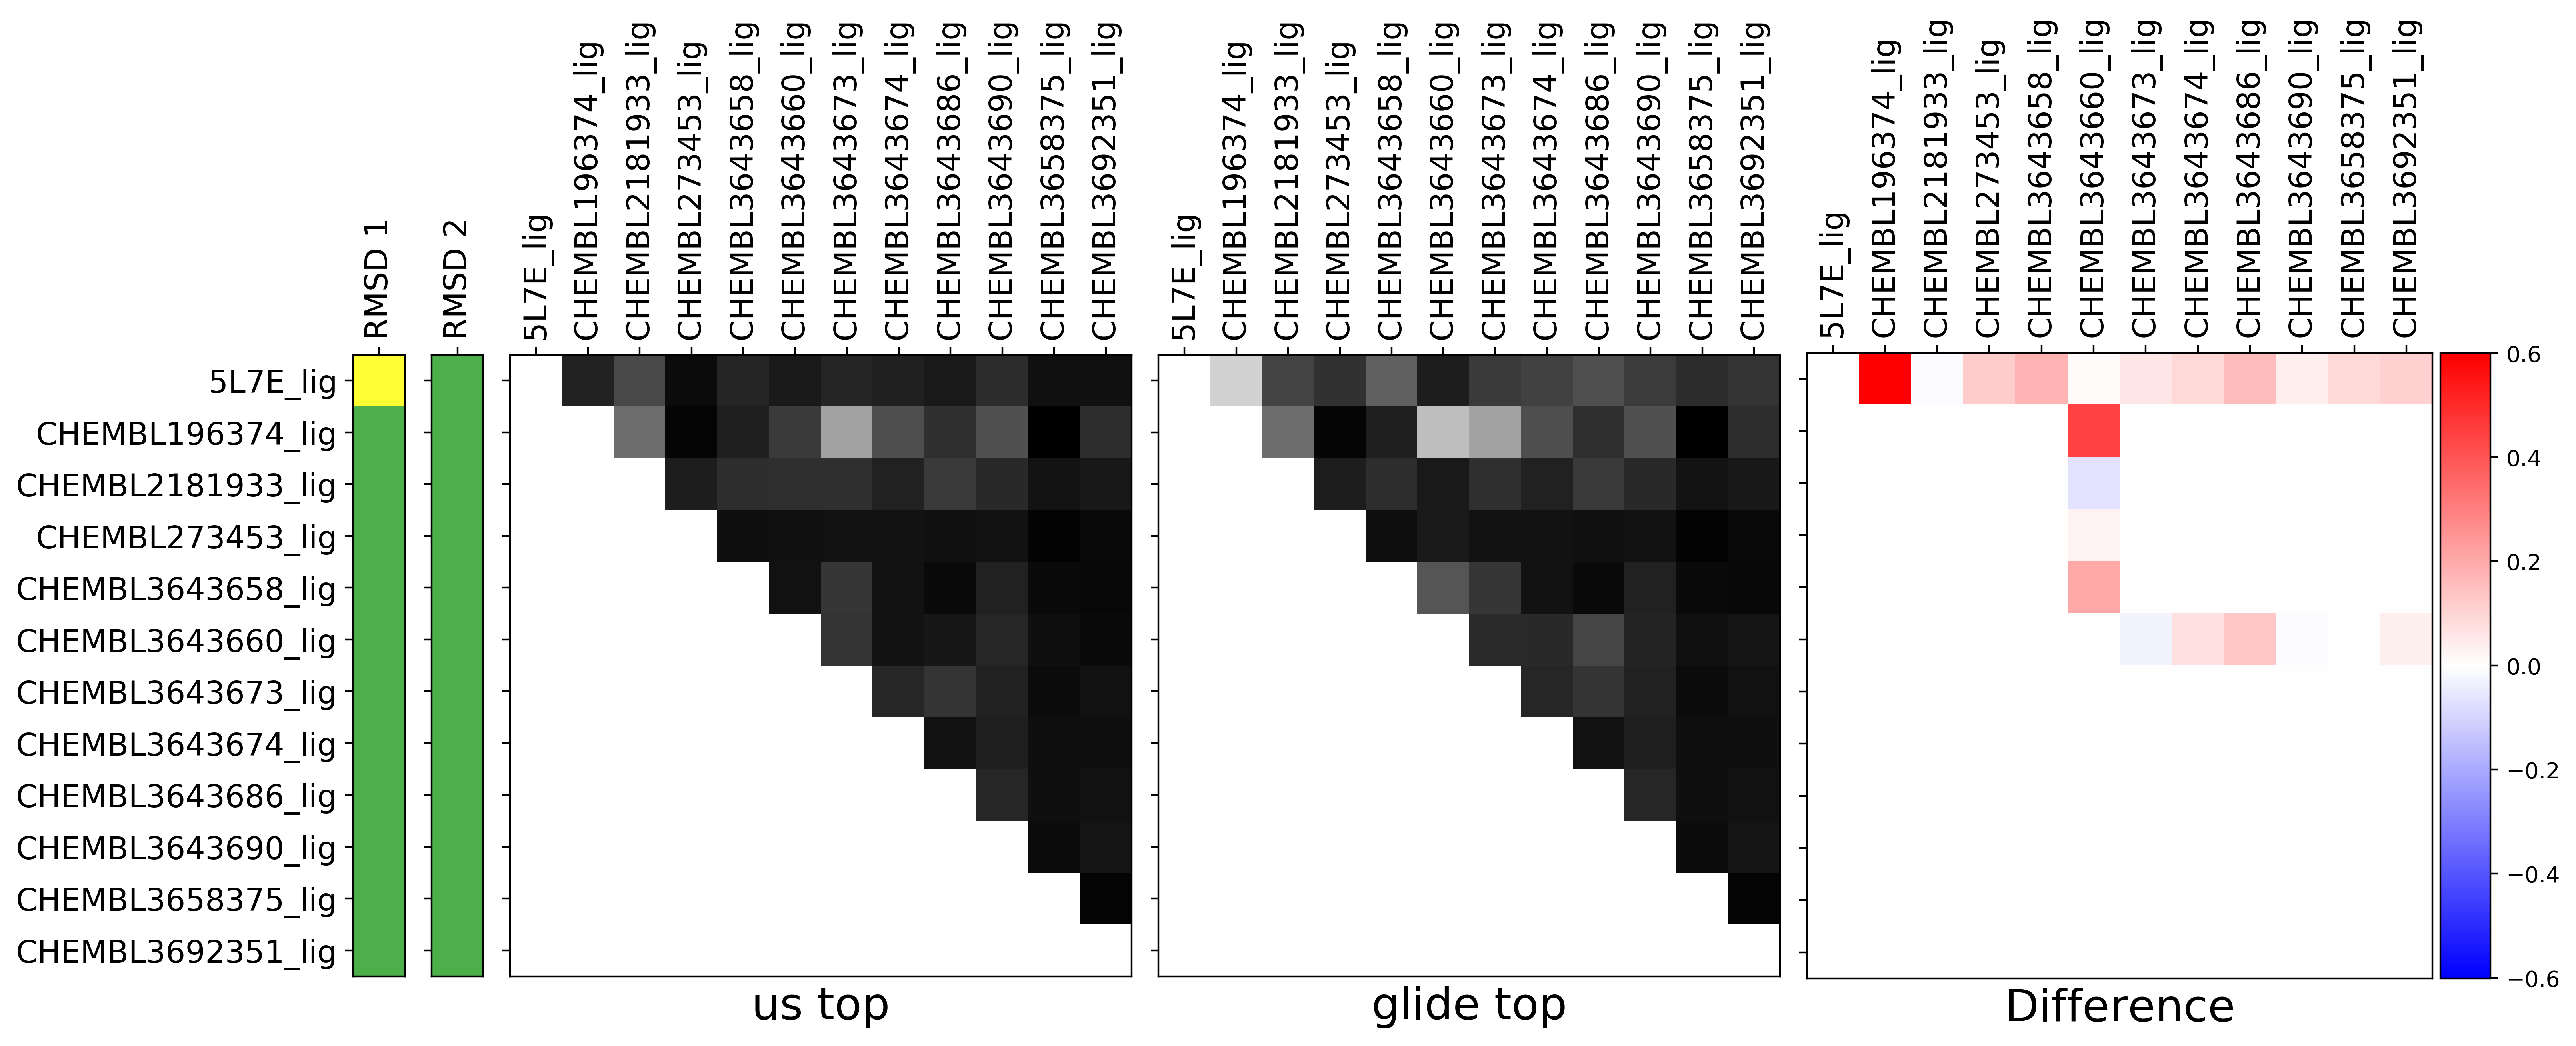

In [36]:
show_prob = True
show_x = True


for k in settings['k_list']:
    if k == 'mcss': continue
    x1, log_p1 = ps.likelihood_and_feature_matrix(pose_cluster, k, l_list)
    x2, log_p2 = ps.likelihood_and_feature_matrix({l:0 for l in l_list}, k, l_list)
    
    if show_prob and np.sum(log_p1) != 0:
        print k, 'probability matrix'
        minval = min(np.min(log_p1[np.nonzero(log_p1)]),np.min(log_p2[np.nonzero(log_p2)]))
        maxval = max(np.max(log_p1[np.nonzero(log_p1)]),np.max(log_p2[np.nonzero(log_p2)]))
        
        show_features(combind_top, log_p1, glide_top, log_p2, l_list, 'us top','glide top',size=1.5,mi=minval,ma=maxval)
        
    if show_x:
        print k, 'x_k matrix'
        minval = min(np.min(x1),np.min(x2))
        maxval = max(np.max(x1),np.max(x2))
    
        show_features(combind_top, x1, glide_top, x2, l_list, 'us top','glide top',size=1.5,mi=minval,ma=maxval)